# Semantic segmentation of aerial images with deep networks

This notebook presents a straightforward PyTorch implementation of a Fully Convolutional Network for semantic segmentation of aerial images. More specifically, we aim to automatically perform scene interpretation of images taken from a plane or a satellite by classifying every pixel into several land cover classes.

As a demonstration, we are going to use the [SegNet architecture](http://mi.eng.cam.ac.uk/projects/segnet/) to segment aerial images over the cities of Vaihingen and Potsdam. The images are from the [ISPRS 2D Semantic Labeling dataset](http://www2.isprs.org/commissions/comm3/wg4/results.html). We will train a network to segment roads, buildings, vegetation and cars.

This work is a PyTorch implementation of the baseline presented in ["Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks "](https://hal.archives-ouvertes.fr/hal-01636145), *Nicolas Audebert*, *Bertrand Le Saux* and *Sébastien Lefèvre*, ISPRS Journal, 2018.

## Requirements

This notebook requires a few useful libraries, e.g. `torch`, `scikit-image`, `numpy` and `matplotlib`. You can install everything using `pip install -r requirements.txt`.

This is expected to run on GPU, and therefore you should use `torch` in combination with CUDA/cuDNN. This can probably be made to run on CPU but be warned that:
  * you have to remove all calls to `torch.Tensor.cuda()` throughout this notebook,
  * this will be very slow.
  
A "small" GPU should be enough, e.g. this runs fine on a 4.7GB Tesla K20m. It uses quite a lot of RAM as the dataset is stored in-memory (about 5GB for Vaihingen). You can spare some memory by disabling the caching below. 4GB should be more than enough without caching.

In [19]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os

import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import psutil
import timeit
import natsort
from natsort import natsorted
from tqdm import tqdm
print('Start ! ')
print ("Memory usage: " + str(psutil.virtual_memory().percent))

Start ! 
Memory usage: 39.4


## Parameters

There are several parameters than can be tuned to use this notebook with different datasets. The default parameters are suitable for the ISPRS dataset, but you can change them to work with your data.

### Examples

  * Binary classification: `N_CLASSES = 2`
  * Multi-spectral data (e.g. IRRGB): `IN_CHANNELS = 4`
  * New folder naming convention : `DATA_FOLDER = MAIN_FOLDER + 'sentinel2/sentinel2_img_{}.tif'`

In [2]:
# Parameters
patch_width = 256
tile_width = 5000

#Memory_tiles = 80  # how many tiles can be stored in CPU memeory
#number_tiles_in_memory = 0 # 
#Intervals = [] # If total tiles = 142, Memory_tiles = 40, the Intervals = [40, 80, 120, 142]
#number_tiles = 0 # number of total tiles
#start_tile_id = 1
#end_tile_id = number_tiles_in_memory

Memory_usage = 90

#data_extension = '.TIF'
#label_extension = '.tif'

WINDOW_SIZE = (patch_width, patch_width) # Patch size

patch_number_image = (int(tile_width / patch_width) + 1) ** 2  
number_sample = 0 # will = patch_number_image * len(all_ids), number of samples of each epoch

STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
FOLDER = r"D:\Dataset\ISPRS" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 20 # Number of samples in a mini-batch
TEST_BATCH_SIZE = 20

#LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
#LABELS = ["0000", "0601", "0610", "0521", "0750", "0311", "0411", "0511", "1001", "0250", "0340", "0360", "0710", "0422", "0890", "0830", "0312", "0110", "0313", "0120", "0550", "0321", "0424", "0211", "0291", "0721", "0810", "0540", "0330", "0522", "0212", "0770", "0790", "1012", "0760", "0530", "0230", "0370", "0920", "0220", "0822", "0821", "0950", "0293", "0930"]
#LABELS = ["00", "06", "05", "07", "03", "04", "10", "02", "99", "01", "08", "09"]
LABELS = ["00", "Road", "Housing area", "Structure", "Forest", "Grass", "Water", "Orchard", "Ignored", "Cropland", "Excavated", "Bareland"]
LABELS = ['Background', 'Sidewalk']
print(LABELS)

#Labels for confusion matrix "8" is the ignored changed area
Label_values = [0, 1]


N_CLASSES = len(LABELS) # Number of classes
#WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
# huan
#WEIGHTS = torch.FloatTensor([0, 0.044289626, 0.01262308, 0.092527621, 0.001295222, 0.010091334, 0.011178817, 0.023869527, 0.036896865, 0.001978375, 1])
WEIGHTS = torch.FloatTensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
WEIGHTS = torch.FloatTensor([1, 5])

#WEIGHTS = WEIGHTS * 100

print('WEIGHTS')
print(WEIGHTS)
CACHE = True # Store the dataset in-memory
#CACHE = False
print('N_CLASSES')
print(N_CLASSES)

print('patch_number_image')
print(patch_number_image)

image_cache = []
label_cache = []

DATASET = 'Potsdam'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    DATA_FOLDER = MAIN_FOLDER + 'Y_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'
    
#FOLDER = r"D:\Dataset"
#MAIN_FOLDER = os.path.join(FOLDER, 'DX')
DATA_FOLDER = r'I:\DVRPC\DOM2015\splited\{}.JPG'
LABEL_FOLDER = r'I:\DVRPC\vector\labels\{}.PNG'
#ERODED_FOLDER = MAIN_FOLDER + '\RemovedTag5\C1\{}.tif'
    
    
    

    


['Background', 'Sidewalk']
WEIGHTS
tensor([1., 5.])
N_CLASSES
2
patch_number_image
400


## Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use ```scikit-image``` for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.

invert_palette:
{(255, 255, 255): 12, (165, 165, 165): 1, (255, 0, 0): 2, (171, 93, 160): 3, (84, 130, 53): 4, (226, 240, 217): 5, (91, 155, 213): 6, (169, 209, 142): 7, (255, 230, 153): 9, (158, 72, 14): 10, (99, 99, 99): 11}


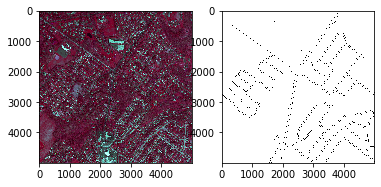

Ground truth in numerical format has shape (5000,5000) : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [3]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = { # Impervious surfaces (white)
           0 : (255,255,255),
           1 : (165,165,165),     # Road
           2 : (255,0,0),   #  Building
           3 : (171,93,160),     # Structure
           4 : (84,130,53),   #  Forest
           5 : (226,240,217),     # Grass
           6 : (91,155,213),   # Water
           7 : (169,209,142),  # Garden
           8 : (255, 255, 255),  # Ignore
           9 : (255,230,153),    # Farmland
           10 : (158,72,14),      # Excavated
           11 : (99,99,99),        # Bared
           12 : (255, 255, 255)
          }       
#
 

invert_palette = {v: k for k, v in palette.items()}

print('invert_palette:')
print(invert_palette)

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread(r'I:\DVRPC\DOM2015\splited\616.JPG')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread(r'I:\DVRPC\vector\labels\616.PNG')
gt_c = convert_to_color(gt)
fig.add_subplot(122)
plt.imshow(gt_c)
plt.show()

# We also check that we can convert the ground truth into an array format
# huan array_gt = convert_from_color(gt)
array_gt = gt
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

We need to define a bunch of utils functions.

In [4]:
# Utils

def get_random_pos(img, window_shape):
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    # huan
    #print('input: ')
    #print(input)
    
    #print('target: ')
    #print(target)
    
    
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
        #print('dim: ')
        #print(dim)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        
        #print('input.size: {}, {}'.format(input.size(0), input.size(1)))
        
        #print('target: ')
        #print(target)
        
        
        #print('output: ')
        #print(output)
        
        
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values, report_path):
    print('range(len(gts))')
    print(range(len(gts)))
    
    print('range(len(predictions))')
    print(range(len(predictions)))
    
    print('range(len(label_values))')
    print(range(len(label_values)))
    
    #report = open(MAIN_FOLDER + 'Test_all_report_100tiles_QS.txt', 'w')
    report = open(report_path, 'w')
    report.writelines('Train ids: ' + str("Confusion matrix :\n"))
    
    cm = confusion_matrix(gts, predictions, label_values)
    
    f1 = f1_score(gts, predictions, average='micro')
    print("F1_score:  micro")
    print(f1)
    
    f1 = f1_score(gts, predictions, average='macro')
    print("F1_score:  macro")
    print(f1)
    
    f1 = f1_score(gts, predictions, average=None)
    print("F1_score: None")
    print(f1)
    
#     accur = accuracy_score(gts, predictions)
#     print("accuracy_score:  ")
#     print(accur)
        
#     rpt = classification_report(gts, predictions, LABELS)
#     print("classification_report:  ")
#     print(accur)    
    
    
    print("Confusion matrix :")
    report.writelines(str("Confusion matrix : \n"))
    print(cm)
    report.writelines(str(cm) +'\n')
    report.writelines('----------- \n ')
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    report.writelines("{} pixels processed \n".format(total))
    report.writelines("Total accuracy : {}% \n".format(accuracy))
    report.writelines("---\n")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    class_accuracy = np.zeros(len(label_values))
    class_recall = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
            class_accuracy[i] =  cm[i,i] / np.sum(cm[:,i])
            class_recall[i] = cm[i,i] / np.sum(cm[i,:])
        except:
            # Ignore exception if there is no element in class i for test set
            pass
        
    report.writelines("F1Score : \n")    
    print("F1Score :")
    
    
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")
    
    print("class_accuracy :") 
    report.writelines("\n class_accuracy : \n")  
    for l_id, score in enumerate(class_accuracy):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")

    print("class_recall :") 
    report.writelines("\n class_recall : \n")  
    for l_id, score in enumerate(class_recall):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")

    print("\nClass summary :") 
    report.writelines("\nClass summary :\n")
    for i in range(len(label_values)):
        print('Correct, Ground truth, Predict: ', LABELS[label_values[i]], cm[i,i], np.sum(cm[i,:]),np.sum(cm[:,i]))
        report.writelines('Correct, Ground truth, Predict: {}: {}, {}, {}\n'.format(LABELS[label_values[i]], cm[i,i], np.sum(cm[i,:]), np.sum(cm[:,i])))
        
    
    report.writelines("---\n")
    
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    
    report.writelines("Kappa: " + str(kappa) +'\n')
    
    report.close()
    
    return accuracy

## Loading the dataset

We define a PyTorch dataset (```torch.utils.data.Dataset```) that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [5]:
# Dataset class

class RS_dataset(torch.utils.data.Dataset):
    def __init__(self, image_cache, label_cache, augmentation=True):
        super(RS_dataset, self).__init__()
        
        self.augmentation = augmentation
         
        
        # List of files
        #self.data_files = [DATA_FOLDER.format(id) for id in ids]
        #self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
#         for f in self.data_files + self.label_files:
#             if not os.path.isfile(f):
#                 raise KeyError('{} is not a file !'.format(f))
        
#         # Initialize cache dicts
#         #if self.cache:
#         self.image_dic = []
#         self.label_dic = []
#             
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return number_sample  
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(image_cache) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
#         if random_idx in self.data_cache_.keys():
#             data = self.data_cache_[random_idx]
#         else:
            # Data is normalized in [0, 1]
        data = image_cache[random_idx]
#             if self.cache:
#                 self.data_cache_[random_idx] = data
            
#         if random_idx in self.label_cache_.keys():
        label = label_cache[random_idx]
#         else: 
#             # Labels are converted from RGB to their numeric values
#             # huan label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
#             label = np.asarray(io.imread(self.label_files[random_idx]), dtype='int64')
#             #huan
#             #print(label)
#             if self.cache:
#                 self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

## Network definition

We can now define the Fully Convolutional network based on the SegNet architecture. We could use any other network as drop-in replacement, provided that the output has dimensions `(N_CLASSES, W, H)` where `W` and `H` are the sliding window dimensions (i.e. the network should preserve the spatial dimensions).

In [6]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x
    
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet5layer(nn.Module):

    #def __init__(self, n_class):
    def __init__(self, in_channels=IN_CHANNELS, n_class=N_CLASSES):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 512)   # Huan  

        self.maxpool = nn.MaxPool2d(2)
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
             
        self.dconv_up4 = double_conv(512 + 512, 512) # HUAN
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)   
        
        x = self.dconv_down5(x)
        
        #x = self.dconv_down5(x)        
        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)               
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out   

class UNet(nn.Module):

    def __init__(self, in_channels=IN_CHANNELS, n_class=N_CLASSES):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

In [7]:
# instantiate the network

#net1 = SegNet()
net1 = UNet5layer()
#net = torch.nn.DataParallel(net1)
net = net1

cnt = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of Network Parameters: {}', cnt)

Number of Network Parameters: {} 19581506


We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.

In [8]:
import os
import urllib

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
# if not os.path.isfile('vgg16_bn-6c64b313.pth'):
#     #weights = urllib.URLopener()
#     weights = urllib.URLopener()
#     weights.retrieve(vgg_url, 'vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load(r'L:\NewYorkCity_sidewalks\vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass


# net.load_state_dict(torch.load(r'unet256_5layer_epoch5_40tiles.pth'))

Mapping features.0.weight to dconv_down1.0.weight
Mapping features.0.bias to dconv_down1.0.bias
Mapping features.1.weight to dconv_down1.2.weight
Mapping features.1.bias to dconv_down1.2.bias
Mapping features.1.running_mean to dconv_down2.0.weight
Mapping features.1.running_var to dconv_down2.0.bias
Mapping features.3.weight to dconv_down2.2.weight
Mapping features.3.bias to dconv_down2.2.bias
Mapping features.4.weight to dconv_down3.0.weight
Mapping features.4.bias to dconv_down3.0.bias
Mapping features.4.running_mean to dconv_down3.2.weight
Mapping features.4.running_var to dconv_down3.2.bias
Mapping features.7.weight to dconv_down4.0.weight
Mapping features.7.bias to dconv_down4.0.bias
Mapping features.8.weight to dconv_down4.2.weight
Mapping features.8.bias to dconv_down4.2.bias
Mapping features.8.running_mean to dconv_down5.0.weight
Mapping features.8.running_var to dconv_down5.0.bias
Mapping features.10.weight to dconv_down5.2.weight
Mapping features.10.bias to dconv_down5.2.bias

Then, we load the network on GPU.

In [9]:
net.cuda()

UNet5layer(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down5): Seque

### Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.

In [10]:
# Load the datasets
print("Loading data")
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["_".join(f.split('_')[3:5]) for f in all_files]
    print('LABEL_FOLDER') # Huan
    print(LABEL_FOLDER)  # Huan
    print('all_files')  # huan
    #print(all_files)  # huan
    
    print('replace') # Huan
    print(LABEL_FOLDER.replace('{}', '*'))  # Huan
elif DATASET == 'Vaihingen':
    #all_ids = 
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    print('LABEL_FOLDER') # Huan
    print(glob(LABEL_FOLDER.replace('{}', '*')))  # Huan
    print('all_files')  # huan
    print(all_files)  # huan
    print('replace') # Huan
    print(LABEL_FOLDER.replace('{}', '*'))  # Huan
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]

all_files = natsorted(glob(LABEL_FOLDER.replace('{}', '*')))
# print('LABEL_FOLDER') # Huan
# print(glob(LABEL_FOLDER.replace('{}', '*')))  # Huan
# print('all_files')  # huan
# print(all_files[0])  # huan
#print('replace') # Huan
#print(LABEL_FOLDER.replace('{}', '*'))  # Huan
all_ids = [os.path.basename(f).split('.')[0] for f in all_files]

# huan
#print('all_ids')
#print(all_ids)

 

    
    
# Random tile numbers for train/test split
#print(all_ids) #Huan
print('len(all_ids)')  # Huan
print(len(all_ids)) 
number_tiles = len(all_ids) 

# train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
# test_ids = list(set(all_ids) - set(train_ids))

# # Exemple of a train/test split on Vaihingen :
# train_ids = ['1', '2','3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
# test_ids = ['5', '21', '15', '30'] 

# # Exemple of a train/test split on Potsdam :
# train_ids = ['2_10', '2_11', '2_12', '3_10', '3_11', '3_12', '4_10', '4_11', '4_12', '5_10', '5_11', '5_12', '6_7', '6_8','6_9', '6_10', '6_11', '6_12', '7_7', '7_8', '7_9', '7_10', '7_11', '7_12']
# test_ids = ['4_12', '7_7', '3_10', '5_10'] 
# test_ids = ['5_10'] 


# train_ids = ['65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '141', '142', '143', '144', '145', '146']
# test_ids = ['20', '60', '100', '140'] 


#train_ids = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90','91','92','93','94','95','96','97','98','99','101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124','125','126','127','128','129','130','131','132','133','134','135','136','137','138','139','141','142','143','144','145','146']
#train_ids = ['40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79']
#test_ids = ['80','81']

#train_ids = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39']

#train_ids = ['80','81','82','83','84','85','86','87','88','89','90','91','92','93','94','95','96','97','98','99','101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124','125','126','127','128','129','130','131','132','133','134','135','136','137','138','139','141','142','143','144','145','146']

train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140']
# test_ids = ['20'] 
train_ids = ['0']
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144','5','12','19','26','33','40','47','54','61','68','75','82','89','96','110','117','124','131','138','145','6','13','20','27','34','41','48','55','62','69','76','83','90','97','104','111','118','125','132','139','146']
#test_ids = ['80']
#test_ids = ['0'] 

# without the first 20 tiles, 122 tiles
train_ids = ['1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144','5','12','19','26','33','40','47','54','61','68','75','82','89','96','110','117','124','131','138','145','6','13','20','27','34','41','48','55','62','69','76','83','90','97','104','111','118','125','132','139','146']

# without the last 20 tiles, 120 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144','5','12','19','26','33','40','47','54','61','68','75','82','89','96','110','117','124','131','138','145']
 
# without the last 40 tiles, 100 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143','4','11','18','25','32','39','46','53','60','67','74','81','88','102','109','116','130','137','144']
 
# without the last 60 tiles, 80 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142','3','10','17','24','31','38','45','52','59','66','73','80','87','94','101','108','115','122','129','136','143']

# without the last 80 tiles, 60 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142']

# without the last 100 tiles, 40 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140','1','8','15','22','29','36','43','50','57','64','71','78','85','92','99','106','113','120','127','134','141','2','9','16','23','30','37','44','51','58','65','72','79','86','93','100','107','121','128','135','142']

# without the last 120 tiles, 20 tiles
train_ids = ['0','7','14','21','28','35','42','49','56','63','70','77','84','91','98','105','112','119','126','140']
train_ids = ['1', '5', '6', '7', '8', '9', '10', '11', '12', '18', '19', '20', '21', '22', '23', '24', '25', '29', '32', '34', '35', '36', '37', '38', '39', '42', '43', '45', '46', '48', '50', '51', '52', '57', '58', '59', '61', '62', '63', '66', '67', '68', '69', '70', '71', '75', '76', '77', '78', '79', '81', '82', '83', '84', '86', '87', '89', '90', '91', '92', '93', '94', '95', '100', '101', '103', '104', '105', '106', '107', '108', '109', '112', '113', '114', '115', '116', '117', '118', '119', '124', '127', '128', '129', '130', '131', '132', '134', '135', '136', '138', '139', '140', '141', '142', '143', '149', '150', '154', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '168', '169', '170', '171', '172', '173', '174', '175', '177', '178', '179', '180', '181', '182', '183', '184', '185', '187', '190', '191', '192', '193', '194', '195', '196', '197', '199', '200', '201', '202', '203', '204', '205', '206', '210', '212', '213', '214', '215', '216', '217', '218', '219', '220', '222', '223', '224', '225', '226', '227', '228', '229', '230', '232', '233', '234', '235', '236', '237', '238', '239', '240', '242', '243', '244', '245', '246', '247', '248', '249', '250', '252', '253', '254', '255', '256', '257', '258', '259', '261', '263', '264', '265', '266', '267', '268', '269', '270', '271', '273', '274', '275', '276', '277', '278', '279', '280', '281', '283', '284', '285', '286', '287', '288', '289', '290', '291', '293', '294', '295', '296', '298', '299', '300', '301', '302', '304', '305', '306', '307', '308', '309', '310', '311', '312', '316', '317', '318', '319', '320', '321', '322', '323', '326', '328', '329', '330', '332', '334', '335', '336', '337', '338', '340', '344', '345', '346', '347', '348', '350', '351', '352', '354', '355', '356', '357', '361', '362', '363', '364', '365', '367', '368', '369', '372', '373', '374', '375', '376', '377', '379', '381', '382', '383', '384', '385', '386', '387', '388', '391', '392', '393', '394', '395', '396', '397', '398', '399', '402', '403', '404', '405', '406', '407', '408', '410', '411', '413', '414', '415', '416', '419', '420', '421', '422', '425', '427', '429', '430', '431', '0']

#test_ids = ['t']
test_ids = ['small'] 
test_ids = ['4','5','6','11','12','13','18','19','20','25','26','27','32','33','34','39','40','41','46','47','48','53','54','55','60','61','62','67','68','69','74','75','76','81','82','83','88','89','90','96','97','102','104','109','110','111','116','117','118','124','125','130','131','132','137','138','139','144','145','146']

test_ids = all_ids
test_ids = ['Q_T35']
test_ids = ['6','13','20','27','34','41','48','55','62','69','76','83','90','97','104','111','118','125','132','139','146','t']
test_ids = ['17', '30', '44', '60', '72', '85', '96', '111', '126', '137', '155', '165', '176', '186', '198', '211', '221', '231', '241', '251', '262', '272', '282', '292', '303', '313', '327', '339', '353', '366', '378', '390', '401', '412', '426']

# train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)

# train_ids = all_ids, 2 * len(all_ids) // 3 + 1)
# test_ids = list(set(all_ids) - set(train_ids))

test_ids = all_ids[::10]
train_ids = list(set(all_ids) - set(test_ids))



#number_sample = len(all_ids) * number_smaple

print("Number of train tiles:", len(train_ids), " Tiles for training : ", train_ids)
print("Number of test tiles:", len(test_ids), " Tiles for testing : ", test_ids)

number_sample =   patch_number_image * len(train_ids)
print('number_sample')
print(number_sample)





Loading data
LABEL_FOLDER
I:\DVRPC\vector\labels\{}.PNG
all_files
replace
I:\DVRPC\vector\labels\*.PNG
len(all_ids)
1436
Number of train tiles: 1292  Tiles for training :  ['2', '486', '874', '1127', '915', '235', '504', '832', '42', '408', '298', '889', '691', '1075', '418', '628', '367', '1108', '1168', '1394', '846', '435', '823', '1073', '211', '1306', '891', '939', '664', '553', '799', '1088', '93', '1253', '223', '73', '404', '1091', '719', '866', '662', '705', '354', '1175', '1', '1192', '268', '981', '659', '445', '882', '405', '808', '1282', '153', '292', '1356', '734', '33', '3', '558', '1318', '527', '1281', '325', '417', '1369', '1269', '29', '1266', '438', '1242', '624', '286', '875', '365', '258', '374', '605', '851', '884', '53', '1429', '1399', '1387', '329', '665', '1136', '1187', '509', '1254', '1263', '1065', '479', '1393', '281', '1107', '236', '872', '1426', '957', '1336', '634', '1374', '1422', '5', '903', '1172', '249', '81', '94', '224', '263', '348', '485', '11

Number of test tiles: 144  Tiles for testing :  ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200', '210', '220', '230', '240', '250', '260', '270', '280', '290', '300', '310', '320', '330', '340', '350', '360', '370', '380', '390', '400', '410', '420', '430', '440', '450', '460', '470', '480', '490', '500', '510', '520', '530', '540', '550', '560', '570', '580', '590', '600', '610', '620', '630', '640', '650', '660', '670', '680', '690', '700', '710', '720', '730', '740', '750', '760', '770', '780', '790', '800', '810', '820', '830', '840', '850', '860', '870', '880', '890', '900', '910', '920', '930', '940', '950', '960', '970', '980', '990', '1000', '1010', '1020', '1030', '1040', '1050', '1060', '1070', '1080', '1090', '1100', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180', '1190', '1200', '1210', '1220', '1230', '1240', '1250', '1260', '1270', '1280', '1290', '1300', '1310', '1320'

### Designing the optimizer

#e use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the ``torch.optim.lr_scheduler`` to reduce the learning rate by 10 after 25, 35 and 45 epochs.

In [11]:
base_lr = 0.0001
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45,55,65,80,90,100], gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 35,45,55,65,80,90,100], gamma=0.1)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.3, patience=500)

In [12]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=TEST_BATCH_SIZE, window_size=WINDOW_SIZE, prefix=None, saved_path=None):
    # Use the network on the test set
    cnt = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print('Number of Network Parameters: {}', cnt)
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    # huan 
    # eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    #eroded_labels = ((io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    #net = torch.nn.DataParallel(net)
    net.eval()
    
    id_index = 0
    
    # huan tqdm is a progress bar for notebook.  zipped:      zipped((1,2),(3,4)) = ((1,3), (2,4))
    for img, gt, in tqdm(zip(test_images, test_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))
        
        print('Processing image: {}'.format(test_ids[id_index]))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
#             if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
#                     _pred = np.argmax(pred, axis=-1)
#                     fig = plt.figure(figsize=(256, 256))
#                     fig.add_subplot(1,3,1)
#                     plt.imshow(np.asarray(255 * img, dtype='uint8'))
#                     fig.add_subplot(1,3,2)
#                     plt.imshow(convert_to_color(_pred))
#                     fig.add_subplot(1,3,3)
#                     plt.imshow(gt)
#                     clear_output()
#                     plt.show()
                     

            # Build the tensor
            torch.no_grad()
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            #image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=torch.no_grad())
            image_patches = Variable(torch.from_numpy(image_patches).cuda())
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure(figsize=(256, 256))
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(convert_to_color(gt))
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt)

        #clear_output()
        accuracy = 0
        # Compute some metrics
        #metrics(pred.ravel(), gt_e.ravel(), Label_values)
        report_path = os.path.join(saved_path, prefix + '_test_report_{}.txt'.format(test_ids[id_index]))
        #accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
        
        #accuracy =  metrics(pred.ravel(), gt.ravel(), Label_values, report_path)
        
        #metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values)
        #img = convert_to_color(pred)
        #plt.imshow(img) and plt.show()
        #io.imsave('./{}_100tiles.png'.format(test_ids[id_index]), img)
        io.imsave(os.path.join(saved_path, '{}_{}.png'.format(prefix,test_ids[id_index])), pred)
        #print('Result was saved: {}'.format(test_ids[id_index]))
        
        io.imsave(os.path.join(saved_path, '{}_{}_color.png'.format(prefix,test_ids[id_index])), convert_to_color(pred))
        print('Result was saved: {}'.format(test_ids[id_index]))
        
        id_index = id_index + 1
        
    report_path = os.path.join(saved_path, prefix + '_test_report_all.txt')    
    accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
            
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [13]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 1):
    losses = np.zeros(100000000)
    mean_losses = np.zeros(100000000)
    print("WEIGHTS:",WEIGHTS)
    weights = weights.cuda()

    #criterion = nn.NLLLoss2d(weight=weights)
    criterion = nn.NLLLoss(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        random.shuffle(train_ids)
#         print('e')
        print('e:',e)
        ee = e
        current_train_idx = 0
        global image_cache
        global label_cache 
        #print(len(train_ids))
        
        
        while current_train_idx < len(train_ids): 
            i = 0
            while psutil.virtual_memory().percent < Memory_usage and current_train_idx < len(train_ids):
                #start_pos = current_train_idx - 1
                #print('current_train_idx: ', current_train_idx)
                #print(io.imread( DATA_FOLDER.replace('{}',str(train_ids[current_train_idx]))))
                image_cache.append(1/255 * np.asarray(io.imread( DATA_FOLDER.replace('{}',str(train_ids[current_train_idx]))).transpose((2,0,1)), dtype='float32'))
                label_cache.append(np.asarray(io.imread(LABEL_FOLDER.replace('{}',str(train_ids[current_train_idx]))), dtype='int64'))
                i += 1
                current_train_idx +=1
            global number_sample
            print('Current percentage of epoch: {:.2f}'.format(current_train_idx / len(train_ids)))
            number_sample = patch_number_image * (i)
            print('Images in memory: ', i)
            print('number_sample: ', number_sample)
                
            print('len label_cache:', len(label_cache))
            
            train_set = RS_dataset(image_cache, label_cache)
            #train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE, num_workers=12) 
            train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE) 
            
            print("len of train_set: ", len(train_set))
            print('len of train_loader: ', len(train_loader))
                                    #huan
                

                #loss = CrossEntropy2d(output, target, weight=weights)
                    #print("Learning rate before and after: ")

                    #val_loss = loss.data[0]d
                    #scheduler.step(val_loss)

            net.train()
            
            for batch_idx, (data, target) in enumerate(train_loader):

                #
                try:                     
                    #print('batch_idx: ', batch_idx)
                    data, target = Variable(data.cuda()), Variable(target.cuda())
                    #print('target: ', target)
                    optimizer.zero_grad()
                    output = net(data)
                    print('shape of output:', output.shape, type(output))
                    
                    loss = CrossEntropy2d(output, target, weight=weights)
                    loss.backward()
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    #print('loss.data[0]: ', loss.data[0])
                except Exception as e:
                    print(e)
                    continue

                #losses[iter_] = loss.data[0]
                losses[iter_] = loss.item()
                mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])

                if iter_ % 1500 == 0:
                    clear_output()
                    rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                    pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                    gt = target.data.cpu().numpy()[0]
                    print('e:',ee)
                    print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                        ee, epochs, batch_idx, len(train_loader),
                        #100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                        100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
                    plt.plot(mean_losses[:iter_]) and plt.show()
                    fig = plt.figure(figsize=(256, 256))
                    fig.add_subplot(131)
                    plt.imshow(rgb)
                    plt.title('RGB')
                    fig.add_subplot(132)
                    plt.imshow(convert_to_color(gt))
                    plt.title('Ground truth')
                    fig.add_subplot(133)
                    plt.title('Prediction')
                    plt.imshow(convert_to_color(pred))
                    plt.show()

                    print('Current percentage of epoch: {:.2f}'.format(current_train_idx / len(train_ids)))
                    print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                        ee, epochs, batch_idx, len(train_loader),
                        #100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                        100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))

                    print("learning rate {}".format(optimizer.param_groups[0]['lr']))
                    
                iter_ += 1


                #huan
                #if scheduler is not None:
                #loss = CrossEntropy2d(output, target, weight=weights)
                    #print("Learning rate before and after: ")

                    #val_loss = loss.data[0]
                    #scheduler.step(val_loss)
                    #scheduler.step()
                    #print(optimizer.param_groups[0]['lr'])

                del(data, target, loss)

            if ee % save_epoch == 0:
    #             We validate with the largest possible stride for faster computing
    #             acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
    #            print(acc)
    #             torch.save(net.state_dict(), './segnet256_epoch{}_ee{}'.format(e, acc))
                torch.save(net.state_dict(), 'unet256_5layer_epoch{}_40tiles.pth'.format(e))
                
            image_cache = []
            label_cache = []
       
    print("Training finished!")
    

    torch.save(net.state_dict(), 'unet__5layer_final_20tiles_201904.pth')
    
    f = open('losses_unet__5layer_final_20tiles_201904.txt','w')
    i = 0
    for i in range(len(losses[:iter_])):
        f.writelines("{} {} {} {}".format(i, losses[i], mean_losses[i], '\n'))
    f.close()
    
    return losses, mean_losses

### Training the network

Let's train the network for 50 epochs. The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. Depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).

In [14]:
# CUDA_LAUNCH_BLOCKING=1 
# losses, mean_losses = train(net, optimizer, 50, scheduler)
#del data_p
#torch.cuda.empty_cache()


In [15]:
import torch.__config__
print(torch.__config__.show())

PyTorch built with:
  - MSVC 191125547
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - OpenMP 200203
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_50,code=compute_50
  - CuDNN 7.5.1
  - Magma 2.5.0
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS=/DWIN32 /D_WINDOWS  /GR  /w /EHa /MP /bigobj -openmp, DISABLE_NUMA=1, PERF_WITH_AVX=1, PERF_WITH_AVX2=1, USE_CUDA=True, USE_EXCEPTION_PTR=1, USE_GFLAGS=OFF, USE_GLOG=OFF, USE_MKL=ON, USE_MKLDNN=OFF, USE_MPI=OFF, USE_NCCL=OFF, USE_NNPACK=OFF, USE_OPENMP=ON, USE_STATIC_DISPATCH=OFF, 



# Inference

In [17]:

# img_list = [r'K:\Research\NJTPA\NJ_images\TIF\DOM20156244.TIF', r'K:\Research\NJTPA\NJ_images\TIF\DOM20156245.TIF', r'K:\Research\NJTPA\NJ_images\TIF\DOM20156243.TIF']
def inference(net, img_list, stride=WINDOW_SIZE[0], batch_size=INFERENCE_BATCH_SIZE, window_size=WINDOW_SIZE, prefix='', saved_path=None):
    #(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=TEST_BATCH_SIZE, window_size=WINDOW_SIZE, prefix=None, saved_path=None):
    
    # Use the network on the test set
    cnt = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print('Number of Network Parameters: {}', cnt)
    test_images = (1 / 255 * np.asarray(io.imread(img), dtype='float32') for img in img_list)
    #test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    # huan 
    # eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    #eroded_labels = ((io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    
    all_preds = []
    #all_gts = []
    
    # Switch the network to inference mode
    #net = torch.nn.DataParallel(net)
    net.eval()
    
    id_index = 0
    
    # huan tqdm is a progress bar for notebook.  zipped:      zipped((1,2),(3,4)) = ((1,3), (2,4))
    for img in tqdm(test_images, total=len(img_list), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))        
        print('Processing image: {}'.format(img_list[id_index]))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
 

            # Build the tensor
            torch.no_grad()
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            #image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=torch.no_grad())
            image_patches = Variable(torch.from_numpy(image_patches).cuda())
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)
 

        #clear_output()
        accuracy = 0
 
        io.imsave(os.path.join(saved_path, '{}{}.png'.format(prefix,os.path.basename(img_list[id_index][:-4]))), pred)
        #print('Result was saved: {}'.format(test_ids[id_index]))
        
        io.imsave(os.path.join(saved_path, '{}{}_color.png'.format(prefix,os.path.basename(img_list[id_index][:-4]))), convert_to_color(pred))
        #print('Result was saved: {}'.format(img_list[id_index]))
        
        id_index = id_index + 1

        

In [20]:
#print(losses)
INFERENCE_BATCH_SIZE = 24
model_path = r'K:\Research\Jupyter_notebooks\unet__5layer_final_201912.pth'
#trained_net = net 
saved_path = r'J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced'
net.load_state_dict(torch.load(model_path))

img_list = glob(r'J:\Workspace_NJ\all\Original_Name\Essex_JPG\*.jpg')
inference(net, img_list, saved_path=saved_path)

 

Number of Network Parameters: {} 19581506


  0%|                                                                                          | 0/183 [00:00<?, ?it/s]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  3.38it/s]
17it [00:06,  3.81it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  1%|▍                                                                                 | 1/183 [00:12<38:18, 12.63s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B11_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  1%|▉                                                                                 | 2/183 [00:22<35:51, 11.89s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  2%|█▎                                                                                | 3/183 [00:33<34:26, 11.48s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s]
17it [00:04,  3.76it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B14_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  2%|█▊                                                                                | 4/183 [00:44<34:10, 11.46s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B15_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  3%|██▏                                                                               | 5/183 [00:55<33:43, 11.37s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██▋                                                                               | 6/183 [01:08<34:42, 11.76s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B6_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  4%|███▏                                                                              | 7/183 [01:19<34:02, 11.60s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B7_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  4%|███▌                                                                              | 8/183 [01:30<33:04, 11.34s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5B8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5B8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  5%|████                                                                              | 9/183 [01:41<32:29, 11.20s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  5%|████▍                                                                            | 10/183 [01:52<32:01, 11.11s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D11_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  6%|████▊                                                                            | 11/183 [02:02<31:04, 10.84s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  7%|█████▎                                                                           | 12/183 [02:14<31:36, 11.09s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D14_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  7%|█████▊                                                                           | 13/183 [02:25<31:15, 11.03s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D15_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  8%|██████▏                                                                          | 14/183 [02:36<31:05, 11.04s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D16_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  8%|██████▋                                                                          | 15/183 [02:48<31:50, 11.37s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D2_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  9%|███████                                                                          | 16/183 [02:59<31:15, 11.23s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D3_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  9%|███████▌                                                                         | 17/183 [03:11<31:38, 11.44s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D4_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 10%|███████▉                                                                         | 18/183 [03:22<31:19, 11.39s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████▍                                                                        | 19/183 [03:34<31:38, 11.58s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D7_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 11%|████████▊                                                                        | 20/183 [03:45<30:57, 11.39s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I5D8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I5D8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 11%|█████████▎                                                                       | 21/183 [03:56<30:38, 11.35s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6A12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6A12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6A12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 12%|█████████▋                                                                       | 22/183 [04:07<30:18, 11.30s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6A16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6A16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6A16_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 13%|██████████▏                                                                      | 23/183 [04:18<29:46, 11.17s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6A8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6A8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6A8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 13%|██████████▌                                                                      | 24/183 [04:30<29:45, 11.23s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B1_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 14%|███████████                                                                      | 25/183 [04:40<29:20, 11.14s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 14%|███████████▌                                                                     | 26/183 [04:51<29:02, 11.10s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B11_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 15%|███████████▉                                                                     | 27/183 [05:03<29:02, 11.17s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 15%|████████████▍                                                                    | 28/183 [05:14<28:49, 11.16s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B13_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 16%|████████████▊                                                                    | 29/183 [05:25<28:42, 11.19s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B14_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 16%|█████████████▎                                                                   | 30/183 [05:36<28:04, 11.01s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B15_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 17%|█████████████▋                                                                   | 31/183 [05:47<28:03, 11.08s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B16_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 17%|██████████████▏                                                                  | 32/183 [05:59<28:29, 11.32s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B2_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 18%|██████████████▌                                                                  | 33/183 [06:10<28:00, 11.20s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B3_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 19%|███████████████                                                                  | 34/183 [06:21<27:53, 11.23s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s]
17it [00:04,  3.72it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B4_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 19%|███████████████▍                                                                 | 35/183 [06:33<28:00, 11.36s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 20%|███████████████▉                                                                 | 36/183 [06:45<28:05, 11.47s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B6_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 20%|████████████████▍                                                                | 37/183 [06:56<27:34, 11.33s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B7_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 21%|████████████████▊                                                                | 38/183 [07:06<27:03, 11.19s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 21%|█████████████████▎                                                               | 39/183 [07:17<26:36, 11.08s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6B9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6B9_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 22%|█████████████████▋                                                               | 40/183 [07:28<26:10, 10.98s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6C12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6C12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6C12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 22%|██████████████████▏                                                              | 41/183 [07:39<26:21, 11.14s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6C4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6C4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6C4_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 23%|██████████████████▌                                                              | 42/183 [07:50<25:26, 10.83s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6C8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6C8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6C8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 23%|███████████████████                                                              | 43/183 [08:01<25:29, 10.93s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D1_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 24%|███████████████████▍                                                             | 44/183 [08:11<25:04, 10.83s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.72it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 25%|███████████████████▉                                                             | 45/183 [08:22<24:55, 10.84s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.51it/s]
17it [00:04,  3.93it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D11_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 25%|████████████████████▎                                                            | 46/183 [08:33<24:36, 10.78s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 26%|████████████████████▊                                                            | 47/183 [08:43<24:00, 10.59s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████▏                                                           | 48/183 [08:55<24:54, 11.07s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D14_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 27%|█████████████████████▋                                                           | 49/183 [09:07<25:01, 11.21s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████▏                                                          | 50/183 [09:18<25:14, 11.39s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 28%|██████████████████████▌                                                          | 51/183 [09:31<25:33, 11.62s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D2_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 28%|███████████████████████                                                          | 52/183 [09:41<24:22, 11.16s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D3_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 29%|███████████████████████▍                                                         | 53/183 [09:52<24:06, 11.13s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D4_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 30%|███████████████████████▉                                                         | 54/183 [10:03<24:05, 11.21s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 30%|████████████████████████▎                                                        | 55/183 [10:14<23:29, 11.02s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D6_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 31%|████████████████████████▊                                                        | 56/183 [10:24<22:58, 10.85s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D7_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 31%|█████████████████████████▏                                                       | 57/183 [10:35<22:50, 10.87s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 32%|█████████████████████████▋                                                       | 58/183 [10:45<22:12, 10.66s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I6D9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I6D9_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 32%|██████████████████████████                                                       | 59/183 [10:56<22:00, 10.65s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\I7B4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\I7B4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████▌                                                      | 60/183 [11:09<23:15, 11.34s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5A10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 33%|███████████████████████████                                                      | 61/183 [11:20<22:54, 11.26s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5A13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A13_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 34%|███████████████████████████▍                                                     | 62/183 [11:31<22:51, 11.33s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5A14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A14_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 34%|███████████████████████████▉                                                     | 63/183 [11:43<22:33, 11.28s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5A15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A15_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 35%|████████████████████████████▎                                                    | 64/183 [11:54<22:39, 11.43s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5A9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5A9_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 36%|████████████████████████████▊                                                    | 65/183 [12:05<21:48, 11.09s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C1_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 36%|█████████████████████████████▏                                                   | 66/183 [12:16<21:41, 11.13s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 37%|█████████████████████████████▋                                                   | 67/183 [12:28<21:53, 11.32s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████                                                   | 68/183 [12:40<22:08, 11.55s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 38%|██████████████████████████████▌                                                  | 69/183 [12:52<22:25, 11.80s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C13_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 38%|██████████████████████████████▉                                                  | 70/183 [13:03<21:53, 11.62s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████▍                                                 | 71/183 [13:15<21:56, 11.75s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████▊                                                 | 72/183 [13:29<22:31, 12.18s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████▎                                                | 73/183 [13:41<22:36, 12.34s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C2_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 40%|████████████████████████████████▊                                                | 74/183 [13:52<21:26, 11.80s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C3_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 41%|█████████████████████████████████▏                                               | 75/183 [14:03<20:49, 11.57s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.90it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C4_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 42%|█████████████████████████████████▋                                               | 76/183 [14:15<20:41, 11.60s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 42%|██████████████████████████████████                                               | 77/183 [14:26<20:29, 11.60s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C6_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 43%|██████████████████████████████████▌                                              | 78/183 [14:37<20:03, 11.46s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C7_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 43%|██████████████████████████████████▉                                              | 79/183 [14:48<19:37, 11.32s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 44%|███████████████████████████████████▍                                             | 80/183 [15:01<19:58, 11.63s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5C9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5C9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 44%|███████████████████████████████████▊                                             | 81/183 [15:14<20:27, 12.03s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D1_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 45%|████████████████████████████████████▎                                            | 82/183 [15:25<19:52, 11.80s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 45%|████████████████████████████████████▋                                            | 83/183 [15:37<19:56, 11.96s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████▏                                           | 84/183 [15:49<19:47, 12.00s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████▌                                           | 85/183 [16:02<20:07, 12.32s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]
17it [00:04,  3.81it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████                                           | 86/183 [16:16<20:25, 12.63s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.81it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 48%|██████████████████████████████████████▌                                          | 87/183 [16:28<20:13, 12.64s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 48%|██████████████████████████████████████▉                                          | 88/183 [16:41<20:12, 12.77s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s]
17it [00:04,  3.76it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████▍                                         | 89/183 [16:55<20:28, 13.07s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 49%|███████████████████████████████████████▊                                         | 90/183 [17:07<19:28, 12.56s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s]
17it [00:04,  3.78it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████▎                                        | 91/183 [17:20<19:33, 12.76s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J5D9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]
17it [00:04,  3.81it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J5D9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████▋                                        | 92/183 [17:32<19:15, 12.70s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A1_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 51%|█████████████████████████████████████████▏                                       | 93/183 [17:43<18:19, 12.22s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 51%|█████████████████████████████████████████▌                                       | 94/183 [17:55<17:41, 11.93s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A11_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 52%|██████████████████████████████████████████                                       | 95/183 [18:06<17:07, 11.68s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 52%|██████████████████████████████████████████▍                                      | 96/183 [18:19<17:36, 12.15s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A13_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 53%|██████████████████████████████████████████▉                                      | 97/183 [18:31<17:14, 12.03s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
17it [00:04,  3.80it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A14_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 54%|███████████████████████████████████████████▍                                     | 98/183 [18:43<16:59, 11.99s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 54%|███████████████████████████████████████████▊                                     | 99/183 [18:56<17:18, 12.37s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████▋                                    | 100/183 [19:10<17:47, 12.87s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A2_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 55%|████████████████████████████████████████████▏                                   | 101/183 [19:22<17:06, 12.52s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A3_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 56%|████████████████████████████████████████████▌                                   | 102/183 [19:33<16:24, 12.16s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████                                   | 103/183 [19:45<16:13, 12.17s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 57%|█████████████████████████████████████████████▍                                  | 104/183 [19:57<15:56, 12.11s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 57%|█████████████████████████████████████████████▉                                  | 105/183 [20:10<15:56, 12.26s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A7_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 58%|██████████████████████████████████████████████▎                                 | 106/183 [20:22<15:39, 12.20s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 58%|██████████████████████████████████████████████▊                                 | 107/183 [20:34<15:32, 12.28s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6A9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6A9_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 59%|███████████████████████████████████████████████▏                                | 108/183 [20:46<15:17, 12.23s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 60%|███████████████████████████████████████████████▋                                | 109/183 [21:00<15:34, 12.62s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████                                | 110/183 [21:13<15:26, 12.69s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 61%|████████████████████████████████████████████████▌                               | 111/183 [21:25<15:09, 12.63s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 61%|████████████████████████████████████████████████▉                               | 112/183 [21:38<15:04, 12.74s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████▍                              | 113/183 [21:52<15:11, 13.03s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████▊                              | 114/183 [22:05<15:04, 13.12s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████▎                             | 115/183 [22:19<14:53, 13.14s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████▋                             | 116/183 [22:32<14:50, 13.30s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s]
17it [00:04,  3.73it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 64%|███████████████████████████████████████████████████▏                            | 117/183 [22:46<14:46, 13.43s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]
17it [00:04,  3.81it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 64%|███████████████████████████████████████████████████▌                            | 118/183 [23:00<14:52, 13.73s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s]
17it [00:04,  3.75it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 65%|████████████████████████████████████████████████████                            | 119/183 [23:15<14:46, 13.86s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████▍                           | 120/183 [23:28<14:26, 13.75s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████▉                           | 121/183 [23:41<13:56, 13.49s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 67%|█████████████████████████████████████████████████████▎                          | 122/183 [23:54<13:31, 13.30s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 67%|█████████████████████████████████████████████████████▊                          | 123/183 [24:08<13:30, 13.50s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6B9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6B9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████▏                         | 124/183 [24:22<13:21, 13.59s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s]
17it [00:04,  3.78it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C1_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 68%|██████████████████████████████████████████████████████▋                         | 125/183 [24:33<12:29, 12.92s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
17it [00:04,  3.75it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████                         | 126/183 [24:46<12:26, 13.09s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s]
17it [00:04,  3.76it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████▌                        | 127/183 [25:01<12:33, 13.46s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.80it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 70%|███████████████████████████████████████████████████████▉                        | 128/183 [25:15<12:40, 13.82s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.33it/s]
17it [00:04,  3.76it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████▍                       | 129/183 [25:29<12:15, 13.63s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████▊                       | 130/183 [25:42<12:01, 13.62s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████▎                      | 131/183 [25:56<11:56, 13.78s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████▋                      | 132/183 [26:10<11:43, 13.79s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.84it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████▏                     | 133/183 [26:22<11:08, 13.37s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████▌                     | 134/183 [26:36<10:53, 13.35s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 74%|███████████████████████████████████████████████████████████                     | 135/183 [26:50<10:53, 13.62s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
17it [00:04,  3.80it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 74%|███████████████████████████████████████████████████████████▍                    | 136/183 [27:02<10:20, 13.20s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████▉                    | 137/183 [27:15<10:05, 13.17s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████▎                   | 138/183 [27:29<09:56, 13.25s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████▊                   | 139/183 [27:42<09:46, 13.33s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6C9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6C9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 77%|█████████████████████████████████████████████████████████████▏                  | 140/183 [27:55<09:31, 13.29s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 77%|█████████████████████████████████████████████████████████████▋                  | 141/183 [28:09<09:26, 13.49s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
17it [00:04,  3.79it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████                  | 142/183 [28:23<09:13, 13.49s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D11.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D11_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 78%|██████████████████████████████████████████████████████████████▌                 | 143/183 [28:33<08:22, 12.56s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]
17it [00:04,  3.81it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 79%|██████████████████████████████████████████████████████████████▉                 | 144/183 [28:45<08:05, 12.44s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████▍                | 145/183 [29:00<08:14, 13.02s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
17it [00:04,  3.81it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 80%|███████████████████████████████████████████████████████████████▊                | 146/183 [29:13<08:02, 13.05s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D15.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]
17it [00:04,  3.78it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████▎               | 147/183 [29:26<07:45, 12.93s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D16.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D16_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 81%|████████████████████████████████████████████████████████████████▋               | 148/183 [29:38<07:27, 12.79s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 81%|█████████████████████████████████████████████████████████████████▏              | 149/183 [29:52<07:21, 12.98s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]
17it [00:04,  3.83it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████▌              | 150/183 [30:05<07:11, 13.08s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]
17it [00:04,  3.82it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████              | 151/183 [30:19<07:06, 13.34s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████▍             | 152/183 [30:32<06:47, 13.16s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████▉             | 153/183 [30:45<06:36, 13.22s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 84%|███████████████████████████████████████████████████████████████████▎            | 154/183 [30:57<06:14, 12.91s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████▊            | 155/183 [31:09<05:54, 12.65s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J6D9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J6D9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████▏           | 156/183 [31:22<05:45, 12.80s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7A2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7A2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 86%|████████████████████████████████████████████████████████████████████▋           | 157/183 [31:35<05:35, 12.89s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7A3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7A3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████           | 158/183 [31:48<05:18, 12.76s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7A4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7A4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 87%|█████████████████████████████████████████████████████████████████████▌          | 159/183 [32:02<05:13, 13.05s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.85it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 87%|█████████████████████████████████████████████████████████████████████▉          | 160/183 [32:15<05:03, 13.19s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B12.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B12_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 88%|██████████████████████████████████████████████████████████████████████▍         | 161/183 [32:26<04:37, 12.61s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B2_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 89%|██████████████████████████████████████████████████████████████████████▊         | 162/183 [32:38<04:18, 12.33s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B3.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████▎        | 163/183 [32:49<04:01, 12.08s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B4.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B4_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 90%|███████████████████████████████████████████████████████████████████████▋        | 164/183 [33:01<03:46, 11.92s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.43it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████████████████████████████████████████▏       | 165/183 [33:13<03:34, 11.93s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B7.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B7_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 91%|████████████████████████████████████████████████████████████████████████▌       | 166/183 [33:24<03:19, 11.71s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\J7B8.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\J7B8_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 91%|█████████████████████████████████████████████████████████████████████████       | 167/183 [33:36<03:07, 11.70s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K5C13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K5C13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████▍      | 168/183 [33:48<02:59, 11.96s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6A1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6A1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████▉      | 169/183 [34:01<02:51, 12.23s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6A5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6A5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 93%|██████████████████████████████████████████████████████████████████████████▎     | 170/183 [34:15<02:43, 12.60s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6A9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6A9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 93%|██████████████████████████████████████████████████████████████████████████▊     | 171/183 [34:29<02:35, 12.97s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6C10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 94%|███████████████████████████████████████████████████████████████████████████▏    | 172/183 [34:40<02:16, 12.40s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6C13.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C13_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 95%|███████████████████████████████████████████████████████████████████████████▋    | 173/183 [34:51<02:00, 12.09s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6C14.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C14_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 95%|████████████████████████████████████████████████████████████████████████████    | 174/183 [35:02<01:45, 11.72s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6C5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 96%|████████████████████████████████████████████████████████████████████████████▌   | 175/183 [35:13<01:32, 11.54s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6C6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C6_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 96%|████████████████████████████████████████████████████████████████████████████▉   | 176/183 [35:24<01:19, 11.34s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K6C9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.87it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K6C9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 97%|█████████████████████████████████████████████████████████████████████████████▍  | 177/183 [35:36<01:08, 11.46s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K7A1.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.89it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A1_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 97%|█████████████████████████████████████████████████████████████████████████████▊  | 178/183 [35:47<00:56, 11.40s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K7A10.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A10_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 98%|██████████████████████████████████████████████████████████████████████████████▎ | 179/183 [35:58<00:45, 11.39s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K7A2.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A2_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 98%|██████████████████████████████████████████████████████████████████████████████▋ | 180/183 [36:09<00:33, 11.22s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K7A5.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.46it/s]
17it [00:04,  3.86it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A5_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 99%|███████████████████████████████████████████████████████████████████████████████▏| 181/183 [36:20<00:22, 11.25s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K7A6.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A6_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 99%|███████████████████████████████████████████████████████████████████████████████▌| 182/183 [36:31<00:10, 10.99s/it]

Processing image: J:\Workspace_NJ\all\Original_Name\Essex_JPG\K7A9.jpg



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]
17it [00:04,  3.88it/s]                                                                                                
                       D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
D:\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: J:\Workspace_NJ\all\Original_Name\Essex_JPG\inferenced\K7A9_color.png is a low contrast image
  warn('%s is a low contrast image' % fname)


### Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take ~15 minutes, but no overlap will take only one minute or two.

In [24]:
model_path = r'K:\OneDrive_NJIT\OneDrive - NJIT\Research\sidewalk\yolact\weights\yolact_base_7_80000.pth'
saved_path = r'L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432\merge'
prefix = os.path.basename(model_path)
# net = net.load_state_dict(torch.load(model_path))
net = torch.load(model_path)
 

In [22]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32, prefix=prefix, saved_path=saved_path)

# for p, id_ in zip(all_preds, test_ids):
#     img = convert_to_color(p)
#     #img = p
#     plt.imshow(img) and plt.show()
#     io.imsave(os.path.join(saved_path, prefix + '_{}_color.png'.format(id_)), img)


AttributeError: 'collections.OrderedDict' object has no attribute 'parameters'

# Calculate metric from classified imagess

In [3]:
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from skimage.color import rgb2gray
import os

def img_to_binary(img):
    
    col = io.imread(img)
    
#     print(col)
#     gray = col.convert('1')
    gray = rgb2gray(col)
    gray = (gray > 0)
    gray = gray.astype(np.uint8)
    print("gray unique values, dtype: ", np.unique(gray), gray.dtype)
#     gray = io.fromarray(gray)
#     gray = gray.point(lambda x: 0 if x<1 else 1, '1')
#     gray = (gray > 0.5).astype(np.int_)
    
#     print("gray unique values after, gray.dtype: ", np.unique(gray), gray.dtype)
    
 
    return gray



In [4]:
files = glob.glob(r'L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\*.tif')
saved_path = r'L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\binary'
for file in files:
#     file = r'L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432\merge\17.tif'
    print(file)
    img = img_to_binary(file)
#     img = img_to_binary_pil(file)
    
#     plt.imshow(img, cmap=plt.cm.gray)
    new_name = os.path.join(saved_path, os.path.basename(file)).replace('.tif', '.png')
    print(new_name)
#     plt.imsave(new_name, img)
    io.imsave(new_name, img, check_contrast=False)
    
    
    newimg = io.imread(new_name)
    print("newimg unique values: ", np.unique(newimg))
    
print("Done.")
# plt.show()

L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\111.tif
gray unique values, dtype:  [0 1] uint8
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\binary\111.png
newimg unique values:  [0 1]
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\126.tif
gray unique values, dtype:  [0 1] uint8
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\binary\126.png
newimg unique values:  [0 1]
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\137.tif
gray unique values, dtype:  [0 1] uint8
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\binary\137.png
newimg unique values:  [0 1]
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\155.tif
gray unique values, dtype:  [0 1] uint8
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\binary\155.png
newimg unique values:  [0 1]
L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding

KeyboardInterrupt: 

In [ ]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=TEST_BATCH_SIZE, window_size=WINDOW_SIZE, prefix=None, saved_path=None):
    # Use the network on the test set
    cnt = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print('Number of Network Parameters: {}', cnt)
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    # huan 
    # eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    #eroded_labels = ((io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    #net = torch.nn.DataParallel(net)
    net.eval()
    
    id_index = 0
    
    # huan tqdm is a progress bar for notebook.  zipped:      zipped((1,2),(3,4)) = ((1,3), (2,4))
    for img, gt, in tqdm(zip(test_images, test_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))
        
        print('Processing image: {}'.format(test_ids[id_index]))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
#             if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
#                     _pred = np.argmax(pred, axis=-1)
#                     fig = plt.figure(figsize=(256, 256))
#                     fig.add_subplot(1,3,1)
#                     plt.imshow(np.asarray(255 * img, dtype='uint8'))
#                     fig.add_subplot(1,3,2)
#                     plt.imshow(convert_to_color(_pred))
#                     fig.add_subplot(1,3,3)
#                     plt.imshow(gt)
#                     clear_output()
#                     plt.show()
                     

            # Build the tensor
            torch.no_grad()
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            #image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=torch.no_grad())
            image_patches = Variable(torch.from_numpy(image_patches).cuda())
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure(figsize=(256, 256))
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(convert_to_color(gt))
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt)

        #clear_output()
        accuracy = 0
        # Compute some metrics
        #metrics(pred.ravel(), gt_e.ravel(), Label_values)
        report_path = os.path.join(saved_path, prefix + '_test_report_{}.txt'.format(test_ids[id_index]))
        #accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
        
        #accuracy =  metrics(pred.ravel(), gt.ravel(), Label_values, report_path)
        
        #metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values)
        #img = convert_to_color(pred)
        #plt.imshow(img) and plt.show()
        #io.imsave('./{}_100tiles.png'.format(test_ids[id_index]), img)
        io.imsave(os.path.join(saved_path, '{}_{}.png'.format(prefix,test_ids[id_index])), pred)
        #print('Result was saved: {}'.format(test_ids[id_index]))
        
        io.imsave(os.path.join(saved_path, '{}_{}_color.png'.format(prefix,test_ids[id_index])), convert_to_color(pred))
        print('Result was saved: {}'.format(test_ids[id_index]))
        
        id_index = id_index + 1
        
    report_path = os.path.join(saved_path, prefix + '_test_report_all.txt')    
    accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), Label_values, report_path)
            
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

### Saving the results

We can visualize and save the resulting tiles for qualitative assessment.

In [ ]:
io.imsave('./{}.png'.format(id_), img)
# for p, id_ in zip(all_preds, test_ids):
#     img = convert_to_color(p)
#     plt.imshow(img) and plt.show()
#     io.imsave('./{}.png'.format(id_), img)

In [ ]:
import cv2 
import numpy as np 


In [22]:
img = cv2.imread(r'D:\Dataset\DX\segnet_final_40tiles_76.png', 0) 
kernel = np.ones((5,5), np.uint8) 
  
# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
img_erosion = cv2.erode(img, kernel, iterations=1) 
img_dilation = cv2.dilate(img, kernel, iterations=1) 
  
cv2.imshow('Input', img) 
cv2.imshow('Erosion', img_erosion) 
cv2.imshow('Dilation', img_dilation) 
  

In [8]:
all_files = glob(r'D:\Dataset\DX\t\*.tif')
for file in all_files:
    new_name = file.replace('.png', '_color')
    new_name = new_name.replace('.tif', '.png')
    p = io.imread(file)
    img = convert_to_color(p)
    io.imsave(new_name, img)
    # for p, id_ in zip(all_preds, test_ids):
    #     img = convert_to_color(p)
    #     plt.imshow(img) and plt.show()
    #     io.imsave('./{}.png'.format(id_), img)

# move tiles

In [2]:
import glob


In [3]:
test_ids =  ['17', '30', '44', '60', '72', '85', '96', '111', '126', '137', '155', '165', '176', '186', '198', '211', '221', '231', '241', '251', '262', '272', '282', '292', '303', '313', '327', '339', '353', '366', '378', '390', '401', '412', '426']
train_ids = ['1', '5', '6', '7', '8', '9', '10', '11', '12', '18', '19', '20', '21', '22', '23', '24', '25', '29', '32', '34', '35', '36', '37', '38', '39', '42', '43', '45', '46', '48', '50', '51', '52', '57', '58', '59', '61', '62', '63', '66', '67', '68', '69', '70', '71', '75', '76', '77', '78', '79', '81', '82', '83', '84', '86', '87', '89', '90', '91', '92', '93', '94', '95', '100', '101', '103', '104', '105', '106', '107', '108', '109', '112', '113', '114', '115', '116', '117', '118', '119', '124', '127', '128', '129', '130', '131', '132', '134', '135', '136', '138', '139', '140', '141', '142', '143', '149', '150', '154', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '168', '169', '170', '171', '172', '173', '174', '175', '177', '178', '179', '180', '181', '182', '183', '184', '185', '187', '190', '191', '192', '193', '194', '195', '196', '197', '199', '200', '201', '202', '203', '204', '205', '206', '210', '212', '213', '214', '215', '216', '217', '218', '219', '220', '222', '223', '224', '225', '226', '227', '228', '229', '230', '232', '233', '234', '235', '236', '237', '238', '239', '240', '242', '243', '244', '245', '246', '247', '248', '249', '250', '252', '253', '254', '255', '256', '257', '258', '259', '261', '263', '264', '265', '266', '267', '268', '269', '270', '271', '273', '274', '275', '276', '277', '278', '279', '280', '281', '283', '284', '285', '286', '287', '288', '289', '290', '291', '293', '294', '295', '296', '298', '299', '300', '301', '302', '304', '305', '306', '307', '308', '309', '310', '311', '312', '316', '317', '318', '319', '320', '321', '322', '323', '326', '328', '329', '330', '332', '334', '335', '336', '337', '338', '340', '344', '345', '346', '347', '348', '350', '351', '352', '354', '355', '356', '357', '361', '362', '363', '364', '365', '367', '368', '369', '372', '373', '374', '375', '376', '377', '379', '381', '382', '383', '384', '385', '386', '387', '388', '391', '392', '393', '394', '395', '396', '397', '398', '399', '402', '403', '404', '405', '406', '407', '408', '410', '411', '413', '414', '415', '416', '419', '420', '421', '422', '425', '427', '429', '430', '431']


In [22]:
files = glob.glob(r'L:\NewYorkCity_sidewalks\COCO\Train\Labels\*.tif')

In [23]:
import os
import shutil
move_to = r'L:\NewYorkCity_sidewalks\COCO\Test\Labels'
for file in files:
    idx = os.path.basename(file).split('_')[0]
#     print(idx)
    if idx in test_ids:
        print(idx)
        shutil.move(file, move_to)

111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137


327
327
327
327
327
327
327
327
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
339
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366


# Copy files

In [13]:
import glob


test_ids =  ['17', '30', '44', '60', '72', '85', '96', '111', '126', '137', '155', '165', '176', '186', '198', '211', '221', '231', '241', '251', '262', '272', '282', '292', '303', '313', '327', '339', '353', '366', '378', '390', '401', '412', '426']
train_ids = ['1', '5', '6', '7', '8', '9', '10', '11', '12', '18', '19', '20', '21', '22', '23', '24', '25', '29', '32', '34', '35', '36', '37', '38', '39', '42', '43', '45', '46', '48', '50', '51', '52', '57', '58', '59', '61', '62', '63', '66', '67', '68', '69', '70', '71', '75', '76', '77', '78', '79', '81', '82', '83', '84', '86', '87', '89', '90', '91', '92', '93', '94', '95', '100', '101', '103', '104', '105', '106', '107', '108', '109', '112', '113', '114', '115', '116', '117', '118', '119', '124', '127', '128', '129', '130', '131', '132', '134', '135', '136', '138', '139', '140', '141', '142', '143', '149', '150', '154', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '168', '169', '170', '171', '172', '173', '174', '175', '177', '178', '179', '180', '181', '182', '183', '184', '185', '187', '190', '191', '192', '193', '194', '195', '196', '197', '199', '200', '201', '202', '203', '204', '205', '206', '210', '212', '213', '214', '215', '216', '217', '218', '219', '220', '222', '223', '224', '225', '226', '227', '228', '229', '230', '232', '233', '234', '235', '236', '237', '238', '239', '240', '242', '243', '244', '245', '246', '247', '248', '249', '250', '252', '253', '254', '255', '256', '257', '258', '259', '261', '263', '264', '265', '266', '267', '268', '269', '270', '271', '273', '274', '275', '276', '277', '278', '279', '280', '281', '283', '284', '285', '286', '287', '288', '289', '290', '291', '293', '294', '295', '296', '298', '299', '300', '301', '302', '304', '305', '306', '307', '308', '309', '310', '311', '312', '316', '317', '318', '319', '320', '321', '322', '323', '326', '328', '329', '330', '332', '334', '335', '336', '337', '338', '340', '344', '345', '346', '347', '348', '350', '351', '352', '354', '355', '356', '357', '361', '362', '363', '364', '365', '367', '368', '369', '372', '373', '374', '375', '376', '377', '379', '381', '382', '383', '384', '385', '386', '387', '388', '391', '392', '393', '394', '395', '396', '397', '398', '399', '402', '403', '404', '405', '406', '407', '408', '410', '411', '413', '414', '415', '416', '419', '420', '421', '422', '425', '427', '429', '430', '431']


In [30]:
from_folder = r'I:\DVRPC\DOM2015\Selected_500\Train'
files = glob.glob(from_folder + '\*.JPG')

test_ids =[os.path.basename(file).replace(".JPG", '') for file in files]
print(len(files))

450


In [36]:
import os
import shutil
import glob

from_folder = r'I:\DVRPC\vector\labels\binary'
copy_to_folder = r'I:\DVRPC\vector\labels\Selected_500\Train'
files = glob.glob(from_folder + '\*.PGw')
for file in files:
    idx = os.path.basename(file).split('.')[0]
#     print(file, idx)
    if idx in test_ids:
        copy_to = os.path.join(copy_to_folder, os.path.basename(file))
#         copy_to = copy_to.replace(".PNG", ".JGw")
        shutil.copyfile(file, copy_to)
        print(file, idx)

I:\DVRPC\vector\labels\binary\1001.PGw 1001
I:\DVRPC\vector\labels\binary\1002.PGw 1002
I:\DVRPC\vector\labels\binary\1009.PGw 1009
I:\DVRPC\vector\labels\binary\1010.PGw 1010
I:\DVRPC\vector\labels\binary\1012.PGw 1012
I:\DVRPC\vector\labels\binary\1013.PGw 1013
I:\DVRPC\vector\labels\binary\1014.PGw 1014
I:\DVRPC\vector\labels\binary\1015.PGw 1015
I:\DVRPC\vector\labels\binary\1017.PGw 1017
I:\DVRPC\vector\labels\binary\1019.PGw 1019
I:\DVRPC\vector\labels\binary\1020.PGw 1020
I:\DVRPC\vector\labels\binary\1024.PGw 1024
I:\DVRPC\vector\labels\binary\1025.PGw 1025
I:\DVRPC\vector\labels\binary\1026.PGw 1026
I:\DVRPC\vector\labels\binary\1032.PGw 1032
I:\DVRPC\vector\labels\binary\1033.PGw 1033
I:\DVRPC\vector\labels\binary\1034.PGw 1034
I:\DVRPC\vector\labels\binary\1038.PGw 1038
I:\DVRPC\vector\labels\binary\1039.PGw 1039
I:\DVRPC\vector\labels\binary\1040.PGw 1040
I:\DVRPC\vector\labels\binary\1041.PGw 1041
I:\DVRPC\vector\labels\binary\1042.PGw 1042
I:\DVRPC\vector\labels\binary\10

I:\DVRPC\vector\labels\binary\346.PGw 346
I:\DVRPC\vector\labels\binary\347.PGw 347
I:\DVRPC\vector\labels\binary\349.PGw 349
I:\DVRPC\vector\labels\binary\363.PGw 363
I:\DVRPC\vector\labels\binary\365.PGw 365
I:\DVRPC\vector\labels\binary\366.PGw 366
I:\DVRPC\vector\labels\binary\367.PGw 367
I:\DVRPC\vector\labels\binary\368.PGw 368
I:\DVRPC\vector\labels\binary\369.PGw 369
I:\DVRPC\vector\labels\binary\375.PGw 375
I:\DVRPC\vector\labels\binary\376.PGw 376
I:\DVRPC\vector\labels\binary\380.PGw 380
I:\DVRPC\vector\labels\binary\395.PGw 395
I:\DVRPC\vector\labels\binary\396.PGw 396
I:\DVRPC\vector\labels\binary\397.PGw 397
I:\DVRPC\vector\labels\binary\398.PGw 398
I:\DVRPC\vector\labels\binary\40.PGw 40
I:\DVRPC\vector\labels\binary\408.PGw 408
I:\DVRPC\vector\labels\binary\411.PGw 411
I:\DVRPC\vector\labels\binary\42.PGw 42
I:\DVRPC\vector\labels\binary\420.PGw 420
I:\DVRPC\vector\labels\binary\421.PGw 421
I:\DVRPC\vector\labels\binary\423.PGw 423
I:\DVRPC\vector\labels\binary\425.PGw 

I:\DVRPC\vector\labels\binary\911.PGw 911
I:\DVRPC\vector\labels\binary\917.PGw 917
I:\DVRPC\vector\labels\binary\923.PGw 923
I:\DVRPC\vector\labels\binary\926.PGw 926
I:\DVRPC\vector\labels\binary\928.PGw 928
I:\DVRPC\vector\labels\binary\929.PGw 929
I:\DVRPC\vector\labels\binary\93.PGw 93
I:\DVRPC\vector\labels\binary\930.PGw 930
I:\DVRPC\vector\labels\binary\931.PGw 931
I:\DVRPC\vector\labels\binary\941.PGw 941
I:\DVRPC\vector\labels\binary\942.PGw 942
I:\DVRPC\vector\labels\binary\943.PGw 943
I:\DVRPC\vector\labels\binary\95.PGw 95
I:\DVRPC\vector\labels\binary\950.PGw 950
I:\DVRPC\vector\labels\binary\956.PGw 956
I:\DVRPC\vector\labels\binary\96.PGw 96
I:\DVRPC\vector\labels\binary\965.PGw 965
I:\DVRPC\vector\labels\binary\966.PGw 966
I:\DVRPC\vector\labels\binary\967.PGw 967
I:\DVRPC\vector\labels\binary\97.PGw 97
I:\DVRPC\vector\labels\binary\975.PGw 975
I:\DVRPC\vector\labels\binary\976.PGw 976
I:\DVRPC\vector\labels\binary\977.PGw 977
I:\DVRPC\vector\labels\binary\978.PGw 978


In [3]:
import os
import shutil
import glob
from tqdm import tqdm

from_folder = r'J:\temp\NYC_jsons'
copy_to_folder = r'J:\temp\NYC_jsons_all'
files = glob.glob(from_folder + '\*.json')
for file in tqdm(files):
    basename = os.path.basename(file) 
    copy_to = os.path.join(copy_to_folder, basename)
    if not os.path.exists(copy_to): 
        shutil.copyfile(file, copy_to)
        

100%|███████████████████████████████████████████████████████████████████████| 632902/632902 [1:05:44<00:00, 135.78it/s]


(256, 256, 4)
(256, 256, 3)


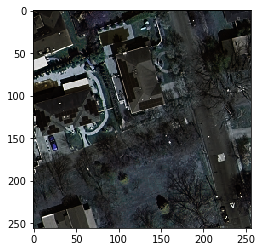

In [61]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread(r'L:\NewYorkCity_sidewalks\COCO\val256_1234\images\0_1_17.tif', cv2.IMREAD_LOAD_GDAL)
print(img.shape)
img = cv2.imread(r'L:\NewYorkCity_sidewalks\COCO\val256_1234\images\0_1_17.tif')
print(img.shape)
plt.imshow(img)

# Caculate the metrics

In [16]:
# read the results
import glob
import os
import logging
 

logger = logging.getLogger()
logger.setLevel('INFO')

# logging.basicConfig(level=logging.INFO)
# logging.debug('This is a debug message')
# logging.info('This is an info message')
# logging.warning('This is a warning message')
# logging.error('This is an error message')
# logging.critical('This is a critical message')

 
from natsort import natsorted
from skimage import io

# from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
# from sklearn.metrics import *
import numpy as np

label_folder = r'L:\NewYorkCity_sidewalks\sidewalks\Test'
label_suf = '.TIF'
label_images = glob.glob(os.path.join(label_folder, '*' + label_suf))
results_suf = '.png'
results_folder = r'L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\binary'
results_images = glob.glob(os.path.join(results_folder, '*' + results_suf))
# print(os.path.join(results_folder, '\*.png'))
results_images = natsorted(results_images)
label_images = natsorted(label_images)
print('result_images: ', results_images[:3])
print('result_images: ', label_images[:3])

LABELS = ['Background', 'Sidewalk']

def metrics(predictions, gts, label_values, report_path):
    print('range(len(gts))')
    print(range(len(gts)))
    
    print('range(len(predictions))')
    print(range(len(predictions)))
    
    print('range(len(label_values))')
    print(range(len(label_values)))
    
    #report = open(MAIN_FOLDER + 'Test_all_report_100tiles_QS.txt', 'w')
    report = open(report_path, 'w')
    report.writelines('Train ids: ' + str("Confusion matrix :\n"))
    
    cm = confusion_matrix(gts, predictions, label_values)
    
    f1 = f1_score(gts, predictions, average='micro')
    print("F1_score:  micro")
    print(f1)
    
    f1 = f1_score(gts, predictions, average='macro')
    print("F1_score:  macro")
    print(f1)
    
    f1 = f1_score(gts, predictions, average=None)
    print("F1_score: None")
    print(f1)
    
#     accur = accuracy_score(gts, predictions)
#     print("accuracy_score:  ")
#     print(accur)
        
#     rpt = classification_report(gts, predictions, LABELS)
#     print("classification_report:  ")
#     print(accur)    
    
    
    print("Confusion matrix :")
    report.writelines(str("Confusion matrix : \n"))
    print(cm)
    report.writelines(str(cm) +'\n')
    report.writelines('----------- \n ')
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    report.writelines("{} pixels processed \n".format(total))
    report.writelines("Total accuracy : {}% \n".format(accuracy))
    report.writelines("---\n")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    class_accuracy = np.zeros(len(label_values))
    class_recall = np.zeros(len(label_values))
    class_precision =  np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
            class_accuracy[i] =  cm[i,i] / np.sum(cm[:,i])
            class_recall[i] = cm[i,i] / np.sum(cm[i,:])
            class_precision[i] = cm[i,i] / np.sum(cm[i,:])
        except:
            # Ignore exception if there is no element in class i for test set
            pass
        
    report.writelines("F1Score : \n")    
    print("F1Score :")
    
    
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")
    
    print("class_accuracy :") 
    report.writelines("\n class_accuracy : \n")  
    for l_id, score in enumerate(class_accuracy):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")

    print("class_recall :") 
    report.writelines("\n class_recall : \n")  
    for l_id, score in enumerate(class_recall):
        print("{}: {}".format(LABELS[label_values[l_id]], score))
        report.writelines("{}: {} \n".format(LABELS[label_values[l_id]], score))
    print("---")

    print("\nClass summary :") 
    report.writelines("\nClass summary :\n")
    for i in range(len(label_values)):
        print('Correct, Ground truth, Predict: ', LABELS[label_values[i]], cm[i,i], np.sum(cm[i,:]),np.sum(cm[:,i]))
        report.writelines('Correct, Ground truth, Predict: {}: {}, {}, {}\n'.format(LABELS[label_values[i]], cm[i,i], np.sum(cm[i,:]), np.sum(cm[:,i])))
        
    
    report.writelines("---\n")
    
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    
    report.writelines("Kappa: " + str(kappa) +'\n')
    
    report.close()
    
    return accuracy

def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1
    
def calcu_results_metric(label_imgs, result_imgs):
    if not isinstance(label_imgs, list):
        label_imgs = [label_imgs]
    if not isinstance(result_imgs, list):
        result_imgs = [result_imgs]
        
    label_names = []
    for file in label_imgs:
        label_names.append(os.path.splitext(os.path.basename(file))[0])
    
    print('label_names, len()： ', len(label_names), label_names)
    
    res_list = []
    lab_list = []
    
    
    for file in result_imgs:
        base_name = os.path.splitext(os.path.basename(file))[0]
        idx_lab = find_element_in_list(base_name, label_names)
        if idx_lab > -1:
#            pass
            try:
                print('base_name: ', base_name)

                res = io.imread(file)
                lab = io.imread(label_imgs[idx_lab])
                lab = lab.astype(np.uint8)
                
                res_list.append(res)
                lab_list.append(lab)

                print("len(res), len(lab): ", len(res.ravel()), len(lab.ravel()))

                print("Label unique values: ", np.unique(lab))
                print("Result unique values: ", np.unique(res))

                acc_report_path =  file.replace(results_suf, '.txt')

                print('acc_report_path:', acc_report_path)

#                 metrics(res.ravel(), lab.ravel(), [0, 1], acc_report_path)
            except Exception as e:
                print("Error:", e )
                continue
                
    acc_report_path =  file.replace(results_suf, '_all.txt')    
    metrics(np.concatenate([p.ravel() for p in res_list]), np.concatenate([p.ravel() for p in lab_list]).ravel(), [0, 1], acc_report_path)
            
#             print("classification_report: \n", metrics.classification_report(lab, res))
            
#             accur = accuracy_score(lab, res)
#             print('accur:', accur)
            
#             recall = metrics.recall_score(lab, res, pos_label=1)
#             print('recall:', recall)
            
            
            
#             precision = precision_score(lab, res, pos_label=1)
#             print('precision:', precision)
        
#             cm = confusion_matrix(gts, predictions, label_values)

#             f1 = f1_score(gts, predictions, average='micro')
#             print("F1_score:  micro")
#             print(f1)

#             f1 = f1_score(lab, res, average='macro')
#             print("F1_score:  macro")
#             print(f1)

#             f1 = f1_score(gts, predictions, average=None)
#             print("F1_score: None")
#             print(f1)
    
#            logger.info(f'base_name: {base_name}')
#             res = io.imread(file) 
#             lab = io.imread(label_imgs[idx_lab])
            
    
calcu_results_metric(label_images, results_images)

result_images:  ['L:\\NewYorkCity_sidewalks\\COCO\\Test256\\classified_padding10_432_2\\merged\\binary\\17.png', 'L:\\NewYorkCity_sidewalks\\COCO\\Test256\\classified_padding10_432_2\\merged\\binary\\30.png', 'L:\\NewYorkCity_sidewalks\\COCO\\Test256\\classified_padding10_432_2\\merged\\binary\\44.png']
result_images:  ['L:\\NewYorkCity_sidewalks\\sidewalks\\Test\\17.TIF', 'L:\\NewYorkCity_sidewalks\\sidewalks\\Test\\30.TIF', 'L:\\NewYorkCity_sidewalks\\sidewalks\\Test\\44.TIF']
label_names, len()：  35 ['17', '30', '44', '60', '72', '85', '96', '111', '126', '137', '155', '165', '176', '186', '198', '211', '221', '231', '241', '251', '262', '272', '282', '292', '303', '313', '327', '339', '353', '366', '378', '390', '401', '412', '426']
base_name:  17
len(res), len(lab):  25000000 25000000
Label unique values:  [0 1]
Result unique values:  [0 1]
acc_report_path: L:\NewYorkCity_sidewalks\COCO\Test256\classified_padding10_432_2\merged\binary\17.txt
base_name:  30
len(res), len(lab):  250

In [14]:
import logging

logging.basicConfig(filename="test.log", filemode="w", format="%(asctime)s %(name)s:%(levelname)s:%(message)s", datefmt="%d-%M-%Y %H:%M:%S", level=logging.DEBUG)
logging.debug('This is a debug message')
logging.info('This is an info message')
logging.warning('This is a warning message')
logging.error('This is an error message')
logging.critical('This is a critical message')

 

2019-12-12 08:27:52:INFO:This is an info message
2019-12-12 08:27:52:INFO:This is an info message
2019-12-12 08:27:52:INFO:This is an info message
2019-12-12 08:27:52:INFO:This is an info message
2019-12-12 08:27:52:WARNING:This is a warning message
2019-12-12 08:27:52:WARNING:This is a warning message
2019-12-12 08:27:52:WARNING:This is a warning message
2019-12-12 08:27:52:WARNING:This is a warning message
2019-12-12 08:27:52:ERROR:This is an error message
2019-12-12 08:27:52:ERROR:This is an error message
2019-12-12 08:27:52:ERROR:This is an error message
2019-12-12 08:27:52:ERROR:This is an error message
2019-12-12 08:27:52:CRITICAL:This is a critical message
2019-12-12 08:27:52:CRITICAL:This is a critical message
2019-12-12 08:27:52:CRITICAL:This is a critical message
2019-12-12 08:27:52:CRITICAL:This is a critical message


In [21]:
# import logging

# logger = logging.getLogger()
# logger.setLevel('DEBUG')
# BASIC_FORMAT = "%(asctime)s:%(levelname)s:  %(message)s"
# DATE_FORMAT = '%Y-%m-%d %H:%M:%S'
# formatter = logging.Formatter(BASIC_FORMAT, DATE_FORMAT)
# chlr = logging.StreamHandler() # 输出到控制台的handler
# chlr.setFormatter(formatter)
# chlr.setLevel('INFO')  # 也可以不设置，不设置就默认用logger的level
# fhlr = logging.FileHandler('example.log') # 输出到文件的handler
# fhlr.setFormatter(formatter)
# logger.addHandler(chlr)
# logger.addHandler(fhlr)
# logger.info('this is info')
# logger.debug('this is debug')
 

2019-12-12 08:29:35:INFO:this is info
2019-12-12 08:29:35:INFO:this is info
2019-12-12 08:29:35:INFO:this is info
2019-12-12 08:29:35:INFO:this is info
2019-12-12 08:29:35:INFO: this is info
2019-12-12 08:29:35:INFO:   this is info
2019-12-12 08:29:35:INFO:  this is info
2019-12-12 08:29:35:INFO:  this is info
2019-12-12 08:29:35:INFO:  this is info
2019-12-12 08:29:35:INFO:  this is info
2019-12-12 08:29:35:INFO:  this is info
